In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
model_path = "/Hair_changer/hair_segmenter.tflite"

In [3]:
DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
    else:
        img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    cv2.imshow('Image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
# 이미지파일 경로

IMAGE_FOLDER = 'image_user'
IMAGE_FILENAMES = ['img4.jpg']

for name in IMAGE_FILENAMES:
    image_path = os.path.join(IMAGE_FOLDER, name)

In [5]:
# Performs resizing and showing the image
images = {name: cv2.imread(os.path.join(IMAGE_FOLDER, name)) for name in IMAGE_FILENAMES}
images.items()
# Preview the image(s)
for name, image in images.items():
    print(name)
    resize_and_show(image) 

img4.jpg


In [6]:
# options
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

In [111]:
from PIL import Image

# 이미지 파일 불러오기
image = Image.open("image_hair/output.png")

# 머리 이미지의 바운딩 박스 계산
bbox = image.getbbox()

# 바운딩 박스의 크기로 이미지 자르기
cropped_image = image.crop(bbox)

# 이미지 저장
cropped_image.save("cropped_output.png")

In [174]:
# 머리카락을 제외한 이미지 추출

with vision.ImageSegmenter.create_from_options(options) as segmenter:

  # Loop through demo image(s)
  for name in IMAGE_FILENAMES:
      image_file_path = os.path.join(IMAGE_FOLDER, name)

      # Create the MediaPipe image file that will be segmented
      image = mp.Image.create_from_file(image_file_path)

      # Retrieve the masks for the segmented image
      segmentation_result = segmenter.segment(image)
      category_mask = segmentation_result.category_mask
      
      image_data = cv2.cvtColor(image.numpy_view(), cv2.COLOR_BGR2RGB)
      # category_mask 를 넘파이 배열로 변환
      category_mask = category_mask.numpy_view()
      
      # Apply hair mask to the original image
      output_image = cv2.bitwise_not(image_data, image_data, mask=category_mask)

      # Show the image with hair segmentation
      resize_and_show(output_image)


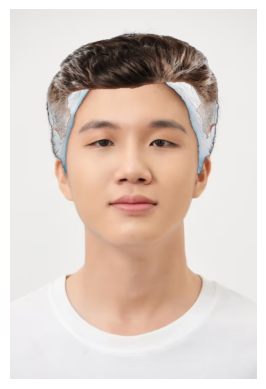

In [165]:
# 머리카락 합성할 이미지 경로
hair_image_path = 'cropped_output.png'


# Create the options that will be used for ImageSegmenter
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.ImageSegmenterOptions(base_options=base_options, output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:
    # Load the hair image
    hair_image = cv2.imread(hair_image_path,cv2.IMREAD_UNCHANGED)

    # Create the MediaPipe image file that will be segmented
    image = mp.Image.create_from_file(image_file_path)

    # Retrieve the masks for the segmented image
    segmentation_result = segmenter.segment(image)
    category_mask = segmentation_result.category_mask

    # Convert the category mask to a numpy array
    category_mask = category_mask.numpy_view()

    # Detect the contours in the category mask
    if cv2.__version__.startswith('3.'):
        _, contours, _ = cv2.findContours(category_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, _ = cv2.findContours(category_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)

        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Resize the hair image to match the size of the bounding box
        resized_hair_image = cv2.resize(hair_image, (w, h))

        # Crop the hair image to match the size of the bounding box
        cropped_hair_image = resized_hair_image[:h, :w]
        
        # Extract the alpha channel from the cropped hair image
        alpha = cropped_hair_image[:, :, 3] / 255.0

        # Create a mask for the alpha channel
        mask = cv2.merge((alpha, alpha, alpha))
        # Mask the output image with the alpha mask
        output_image = image.numpy_view().copy()
        output_image = cv2.bitwise_not(output_image, output_image, mask=category_mask)
        #BGR to RGB
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        output_image[y:y+h, x:x+w] = output_image[y:y+h, x:x+w] * (1 - mask) + cropped_hair_image[:, :, :3] * mask
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

        # Display the output image
        plt.imshow(output_image)
        plt.axis('off')  # Optional: Remove axis labels
        plt.show()
        cv2.imwrite('output.png', output_image)


In [176]:
# Load the composite image
composite_image = cv2.imread('output.png')
# Perform inpainting to fill the hair region in the composite image
inpainted_image = cv2.inpaint(composite_image, category_mask, 1, cv2.INPAINT_TELEA)
cv2.imshow('Image', inpainted_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
        # # Create a mask for feathering
        # feather_amount = 50  # 조절 가능한 피더링 양
        # sigma = 10  # 표준편차 값
        
        # kernel_size = (feather_amount * 2 + 1, feather_amount * 2 + 1)  # 홀수 크기의 커널

        # feather_mask = cv2.GaussianBlur(mask, kernel_size, sigma)

        # # Normalize the feather mask
        # feather_mask = feather_mask / 255.0

        # # Invert the feather mask
        # feather_mask = 1 - feather_mask

        # # Apply feathering to the output image
        # output_image[y:y+h, x:x+w] = output_image[y:y+h, x:x+w] * feather_mask + cropped_hair_image[:, :, :3] * mask
        # # Convert BGR to RGB